In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
csv_files = ['sqli.csv','sqliv2.csv','SQLiV3.csv']
df = []
for f in csv_files:
  try:
    dataframe = pd.read_csv('/content/drive/MyDrive/data/SQLi/'+f,encoding='utf-16')
  except UnicodeError:
    dataframe = pd.read_csv('/content/drive/MyDrive/data/SQLi/'+f,encoding='utf-8')
  df.append(dataframe)

df = pd.concat(df, ignore_index=True)
sentences = df['Sentence'].tolist()
labels = df['Label'].tolist()
not_sql= (df['Label']==0).sum()
sql = (df['Label']==1).sum()
print("SQL attacks", sql)
print("Non-SQL attacks",not_sql)


SQL attacks 12584
Non-SQL attacks 25377


In [ ]:
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

glove_file = '/content/drive/MyDrive/data/SQLi/GloVe/glove.840B.300d.txt'
glove_embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        if len(values) != 301:
          continue
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

In [ ]:
from sklearn.model_selection import train_test_split

#Tokenize sentences
tokenized_sentences = [word_tokenize(str(sentence)) for sentence in sentences]
seq_tokens = []
for sentence in tokenized_sentences:
  weighted_sum = np.zeros((300,)) #embedding of whole sentence
  count = 0
  for word in sentence:
    count+=1
    if word in glove_embeddings:
      embedding = glove_embeddings[word]
    else:
      embedding = np.zeros((300,))
    weighted_sum+= embedding
  if count > 0:
    seq_tokens.append(weighted_sum / count)
  else:
    seq_tokens.append(weighted_sum)

In [ ]:
import torch
import torch.nn as nn
import math
from torch.utils.data import TensorDataset, DataLoader
train_sentences, test_sentences, train_labels, test_labels = train_test_split(seq_tokens, labels, test_size=0.2, random_state=42)
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.2, random_state=42)
index_train =[] #index where nan
index_test = []
for i in range(0,len(train_labels)):
  if (train_labels[i]=='0'or train_labels[i]=='1'or train_labels[i]==1 or train_labels[i]==0):
    train_labels[i]=int(train_labels[i])
  else:
    index_train.append(i)

for i in range(0,len(test_labels)):
  if (test_labels[i]=='0'or test_labels[i]=='1'or test_labels[i]==1 or test_labels[i]==0):
    test_labels[i]=int(test_labels[i])
  else:
    index_test.append(i)

train_labels = np.delete(train_labels,index_train)
test_labels = np.delete(test_labels,index_test)
train_sentences = np.delete(train_sentences,index_train,axis = 0)
test_sentences = np.delete(test_sentences,index_test, axis = 0)
train_labels = [int(x) for x in train_labels] #Convert string labels to int
test_labels = [int(x) for x in test_labels]
train_dataset = TensorDataset(torch.tensor(train_sentences),torch.tensor(train_labels).unsqueeze(1))
test_dataset = TensorDataset(torch.tensor(test_sentences),torch.tensor(test_labels).unsqueeze(1))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)
train_labels = torch.tensor(train_labels)

In [ ]:
#hyperparameters
output_dim = 32
hidden_dim = 100
num_layers = 2
dropout = 0.5
batch_size = 32
lr = 0.001
num_epochs = 5


In [ ]:
def custom_collate_fn(batch):
    # `batch` is a list of tuples (sample, target)
    # where `sample` is a tensor of shape (seq_len, input_size)
    # and `target` is a tensor of shape (1,)
    # We want to convert this list of tuples into a single batch

    # Stack the samples along the batch dimension to create a batch of shape (batch_size, seq_len, input_size)
    samples = torch.stack([sample for sample, target in batch], dim=0)

    # Stack the targets along the batch dimension to create a batch of shape (batch_size,)
    targets = torch.stack([target for sample, target in batch], dim=0)

    return samples, targets


In [ ]:
X_train_tensors = torch.Tensor(train_sentences)
X_test_tensors = torch.Tensor(test_sentences)

y_train_tensors = torch.Tensor(train_labels)
y_test_tensors = torch.Tensor(test_labels)

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True,bidirectional=False) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
model = LSTM1(2,32,100,1)
print(model)

LSTM1(
  (lstm): LSTM(32, 100, batch_first=True)
  (fc_1): Linear(in_features=100, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
print(X_test_tensors_final.shape)
print(X_train_tensors_final.shape)

torch.Size([13707, 1, 300])
torch.Size([43898, 1, 300])


In [ ]:
import torch.optim as optim
import torch
import time
import os

model = LSTM1(1,300,100,1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

save_path = '/content/drive/My Drive/models/model_params.pt'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)

total_loss = 0.0
iter = 0

min_test_loss = 1
#to time the training
start_time = time.time()
for epoch in range(num_epochs):
  print("Epoch",epoch)
  running_loss = 0.0
  for i, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    inputs, targets = batch
    outputs = model(inputs.unsqueeze(1).to(torch.float))
    outputs = nn.functional.sigmoid(outputs) # Apply sigmoid activation so that values are between 0 and 1
    targets = targets.to(torch.float)
    batch_loss = criterion(outputs, targets)
    batch_loss.backward()
    # Clip the gradients to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()
    if i % 20 == 0:
      # logging.info(f"Step [{step}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
      print(f'Step [{i}/{len(train_dataloader)}], Loss: {batch_loss.item():.4f}')    
    # Update the running loss
model.eval()
end_time = time.time()
elapsed_time_lstm = end_time - start_time
print(f'Time taken to train: {elapsed_time_lstm} seconds')

model_state_dict = model.state_dict()
torch.save(model_state_dict, 'model_params.pt')
correct = 0
total = 0
for i, batch in enumerate(test_dataloader):
  optimizer.zero_grad()
  inputs, targets = batch
  outputs = model(inputs.unsqueeze(1).to(torch.float))
  outputs = nn.functional.sigmoid(outputs) # Apply sigmoid activation so that values are between 0 and 1
  predicted = torch.round(outputs).int()
  predicted = predicted.view(-1)
  targets = targets.view(-1)
  correct+= (predicted == targets).sum().item()
  # count the total number of samples
  total += 32
accuracy = 100 * correct / total
print('Accuracy:', accuracy)

Epoch 0
Step [0/1372], Loss: 0.6929
Step [20/1372], Loss: 0.5945
Step [40/1372], Loss: 0.3679
Step [60/1372], Loss: 0.1175
Step [80/1372], Loss: 0.0404
Step [100/1372], Loss: 0.0692
Step [120/1372], Loss: 0.0533
Step [140/1372], Loss: 0.1151
Step [160/1372], Loss: 0.0404
Step [180/1372], Loss: 0.0079
Step [200/1372], Loss: 0.0202
Step [220/1372], Loss: 0.0526
Step [240/1372], Loss: 0.0106
Step [260/1372], Loss: 0.1177
Step [280/1372], Loss: 0.0044
Step [300/1372], Loss: 0.0080
Step [320/1372], Loss: 0.0051
Step [340/1372], Loss: 0.0085
Step [360/1372], Loss: 0.0068
Step [380/1372], Loss: 0.0034
Step [400/1372], Loss: 0.0065
Step [420/1372], Loss: 0.0028
Step [440/1372], Loss: 0.0055
Step [460/1372], Loss: 0.0496
Step [480/1372], Loss: 0.0033
Step [500/1372], Loss: 0.0029
Step [520/1372], Loss: 0.0217
Step [540/1372], Loss: 0.0026
Step [560/1372], Loss: 0.0086
Step [580/1372], Loss: 0.0064
Step [600/1372], Loss: 0.0048
Step [620/1372], Loss: 0.0371
Step [640/1372], Loss: 0.0033
Step [66

In [ ]:
last_10_inputs = y_test_tensors[-10:]
last_10_labels = test_labels[-10:]
last_10_predicted = outputs[-10:]
print("+------------+-------+----------+")
print("| Input      | Label | Predicted|")
print("+------------+-------+----------+")
for i in range(10):
    input_str = str(last_10_inputs[i].tolist())
    label_str = str(last_10_labels[i])
    predicted_str = str(torch.round(last_10_predicted[i]).item())
    print(f"| {input_str:<10} | {label_str:<5} | {predicted_str:<8} |")
print("+------------+-------+----------+")


+------------+-------+----------+
| Input      | Label | Predicted|
+------------+-------+----------+
| 0.0        | 0     | 0.0      |
| 1.0        | 1     | 1.0      |
| 0.0        | 0     | 0.0      |
| 0.0        | 0     | 0.0      |
| 1.0        | 1     | 1.0      |
| 0.0        | 0     | 0.0      |
| 0.0        | 0     | 0.0      |
| 0.0        | 0     | 0.0      |
| 0.0        | 0     | 0.0      |
| 0.0        | 0     | 0.0      |
+------------+-------+----------+


In [ ]:
#Random forest
import sklearn
import pickle
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from joblib import dump,load

random_forest = RandomForestClassifier(bootstrap = True, random_state = 18)
start_time = time.time()
random_forest.fit(train_sentences, train_labels)
dump(random_forest, 'random_forest_model.joblib')
end_time = time.time()
elapsed_time_forest = end_time-start_time
print(f'Time taken to train RandomForest: {elapsed_time_forest} seconds')
predictions = random_forest.predict(test_sentences)
accuracy_rf = random_forest.score(X_test_tensors_final.squeeze(1), predictions)
print("Accuracy score",accuracy_rf)



Time taken to train RandomForest: 69.04466676712036 seconds
Accuracy score 1.0


In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

svm_classifier = svm.SVC(kernel='linear')
print(svm_classifier)
start_time = time.time()
svm_classifier.fit(train_sentences, train_labels)
end_time = time.time()
elapsed_time_svm = end_time-start_time
print(f'Time taken to train SVM: {elapsed_time_svm} seconds')
y_pred = svm_classifier.predict(test_sentences)
accuracy_svm= svm_classifier.score(test_sentences, test_labels)
print("Accuracy:", accuracy_svm)



SVC(kernel='linear')
Time taken to train SVM: 19.330122470855713 seconds
Accuracy: 0.9939446997884293


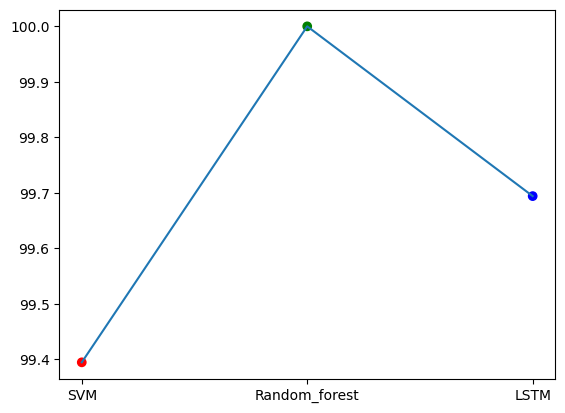

In [ ]:
import matplotlib.pyplot as plt
score1 = svm_classifier.score(test_sentences, test_labels)
score2 = random_forest.score(X_test_tensors_final.squeeze(1), predictions)
score3 = accuracy
plt.figure()
colors = ['red','green','blue']
# Plot the points using the scatter function
plt.scatter(['SVM','Random_forest','LSTM'],[score1*100,score2*100,score3],c=colors)
plt.plot(['SVM','LSTM','Random_forest'],[score1*100,score2*100,score3])
# Show the plot
plt.show()